# Introduce heurisitic to evaluate explanability of model

# Comparing prediction quality

<table>
<tr><th>Accuracy </th><th>F-1 Score</th></tr>
<tr><td>

| #LSTM | Unidirectional | Bidirectional |
| --    |:--:            | :--:          |
| 1     | 0.7768         | 0.7933        |
| 2     | 0.7665         | 0.7629        |
| 3     | 0.7485         | 0.7571        |

</td><td>

| #LSTM | Unidirectional | Bidirectional |
| --    |:--:            | :--:          |
| 1     | 0.7767         | 0.7933        |
| 2     | 0.7665         | 0.7629        |
| 3     | 0.7485         | 0.7571        |
    
</td></tr> 
</table>



In [1]:
%load_ext autoreload
%autoreload 2

from IPython.display import display, HTML
import sys
sys.path.append("./../src")

In [2]:
import spacy
import pickle
import torch
import matplotlib.pyplot as plt
from scipy.special import softmax

from data.collate import *
from data.snli.dataset import *
from data.pipeline import *
from helpers import hightlight_txt

from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

In [3]:
spacy_model = spacy.load('en_core_web_md')
labels = ['neutral', 'entailment']
cache_path = '../src/_out'
data_path='/Users/dunguyen/Dataset/snli'
nb_data = 9

In [4]:
def visualize(lemma1, lemma2, attention1, attention2, pred, y_true):
    html = '<table>'
    html += '<tr> <th>Document 1</th> <th>Document 2</th><th>Prediction</th><th>Label</th> </tr>'
    for i in range(attention1.size(0)):
        html += '<tr> <td>' +  hightlight_txt(lemma1[i], attention1[i]) + '</td><td>' + hightlight_txt(lemma2[i], attention2[i]) +'</td><td>' + str(pred[i].item()) +'</td><td>' + str(y_true[i].item()) +'</td></tr>'
    html += '</table>'
    return html

In [5]:
testset = SNLIDataset('test', cache_path=cache_path, shuffle=False).select_class(['neutral', 'entailment'])
testset.data = testset.data[:nb_data].reset_index(drop=False)

text_pipeline = TextPipeline(spacy_model)
vocab = build_vocab(testset, cache_path=cache_path, pipeline=text_pipeline)

num_pipeline = text_pipeline.numericalizer(vocab)
collate_fn = StandardCollate(multiclass=True, padding=vocab['<pad>'], pipeline=num_pipeline)
test_iterator = DataLoader(testset, collate_fn=collate_fn, batch_size=nb_data, shuffle=False)

tokens1 = text_pipeline(testset.data['premise'])
tokens2 = text_pipeline(testset.data['hypothesis'])

Load test: 100%|██████████| 1/1 [00:00<00:00, 31.53it/s, load_from=../src/_out/dataset/snli/test.csv]
Load vocab ../src/_out/dataset/snli/vocab_standard.pkl: 100%|██████████| 1/1 [00:00<00:00, 98.38it/s]


In [6]:
test_iterator = DataLoader(testset, collate_fn=TextCollate('<pad>', text_pipeline), batch_size=nb_data, shuffle=False)

### Working

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [8]:
# Note: we allow det 'the' since it'll be filtered out by 'is_stop'
pos_filter = ['VERB', 'PROPN', 'NOUN', 'ADJ']
m_syntax = [None] * nb_data
m_vector = [None] * nb_data
vectors = [None] * nb_data
tokens = [None] * nb_data

k = 0

for line, data in enumerate(testset):
    
    x, y = data
    m_syntax[line] = [None, None]
    m_vector[line] = [None, None]
    vectors[line] = [None, None]
    tokens[line] = [None, None]
    
    for i in range(2):
        docs = spacy_model(x[i])
        # Mask if syntaxically acceptable
        syntax_mask = np.array([(not tk.is_stop) and (tk.pos_ in pos_filter) for tk in docs ])
        # Mask if has vector
        vectorable_mask = np.array([tk.has_vector for tk in docs])
        
        m_syntax[line][i] = syntax_mask
        m_vector[line][i] = vectorable_mask
        
        vectors[line][i] = [tk for tk in docs]
        tokens[line][i] = [tk.text for tk in docs]
        
# Construct similarity matrix
sim_matrix = [None] * nb_data
for line in range(len(testset)):
    
    premise, hypothesis = vectors[line]
    
    # p = premise, h = hypothesis
    m = [[p.similarity(h) for h in hypothesis] for p in premise]
    
    sim_matrix[line] = np.array(m)
    

    
mask_vect = [None] * nb_data

for line in range(nb_data):
    mask_vect[line] = [np.multiply(m_syntax[line][i], m_vector[line][i]) for i in range(2) ] 

def repeat_matrix(vector, repeat, axis):
    return np.repeat(np.expand_dims(vector, axis=axis), repeat, axis=axis)

mask = [None] * nb_data
for line in range(nb_data):
    m1 = repeat_matrix(mask_vect[line][0], mask_vect[line][1].shape[0], axis=1).astype(float)
    m2 = repeat_matrix(mask_vect[line][1], mask_vect[line][0].shape[0], axis=0).astype(float)
    mask[line] = np.multiply(m1, m2)
    
masked_sim = [ np.multiply(mask[line], sim_matrix[line]) for line in range(nb_data) ]

heuristic_attention = [
    [
        softmax(masked_sim[line].sum(axis=1)),
        softmax(masked_sim[line].sum(axis=0))
    ] for line in range(nb_data)
]

Similarity matrix (demonstration)

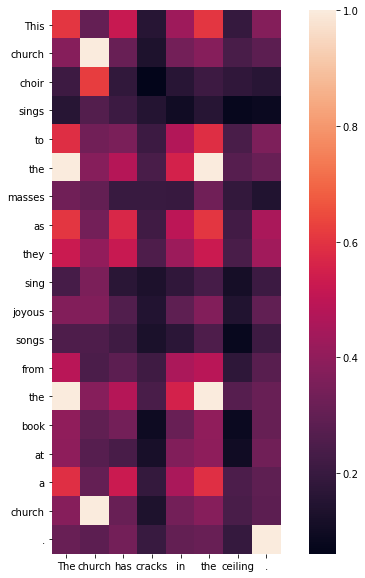

In [9]:
plt.figure(figsize = (10,10))
ax = sns.heatmap(sim_matrix[0], yticklabels=tokens[0][0], xticklabels=tokens[0][1] , square = True)
plt.show()

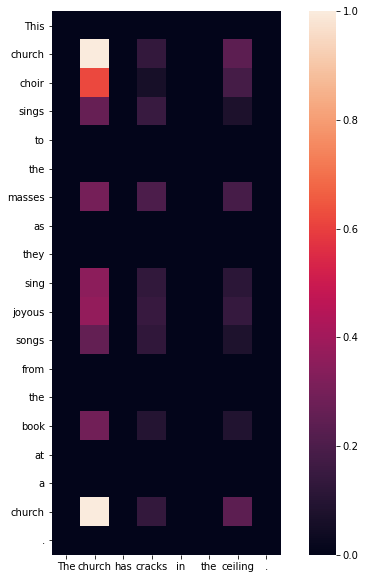

In [10]:
plt.figure(figsize = (10,10))
ax = sns.heatmap(masked_sim[0], yticklabels=tokens[0][0], xticklabels=tokens[0][1] , square = True)
plt.savefig('demo_heuristic.png', dpi=600)
plt.show()

Bundle heuristic in python code

In [11]:
from helpers.tools import heuristic

In [14]:
h = heuristic(testset, spacy_model)

In [24]:
for i in range(2):
    for line in range(nb_data):
        if not np.array_equal(h[line][i], heuristic_attention[line][i]):
            print('Wrong case: ', i, line)